In [1]:
PROCESSES_COUNT = 30

print("Importing...")
from multiprocessing import Pool

import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 2660 result folders
Loading data with 30 processes...


100%|██████████| 2660/2660 [00:34<00:00, 76.24it/s] 


In [17]:
# PLOT SETTINGS:
FAST_REACTOR = False # True if epithermal, False if thermal
NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
USE_SAMPLED_DATA = True
SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

folder_name = f"plots-{NEUTRON_TEMP}-{SAMPLED_STRING}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

df.head()

,k-eff,k-eff-std,result_path,fast_reactor,neutron_temp,partition_text,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,seed,use_sampled_data,rel_err_k-eff-std,rho,rho-std,rho-pcm,rho-std-pcm,rel-err_rho-std
2,0.991987,0.000312,../results/RUNDATA_R5_3,False,THERMAL,FULL,30000,300,50,1.676557e+09,1.676557e+09,134.302,8.330689e+09,True,0.031477,-0.008078,0.000317,-807.808807,31.731167,3.928054
3,0.990742,0.000324,../results/RUNDATA_R5_4,False,THERMAL,FULL,30000,300,50,1.676557e+09,1.676558e+09,132.657,9.552417e+09,True,0.032705,-0.009345,0.000330,-934.470368,33.010283,3.532513
4,0.989740,0.000323,../results/RUNDATA_R5_5,False,THERMAL,FULL,30000,300,50,1.676558e+09,1.676558e+09,134.363,3.496315e+09,True,0.032669,-0.010366,0.000330,-1036.600072,33.007574,3.184215
5,0.991794,0.000276,../results/RUNDATA_R5_6,False,THERMAL,FULL,30000,300,50,1.676558e+09,1.676558e+09,134.214,4.599990e+09,True,0.027852,-0.008274,0.000281,-827.381016,28.082375,3.394128
6,0.989048,0.000322,../results/RUNDATA_R5_7,False,THERMAL,FULL,30000,300,50,1.676558e+09,1.676558e+09,132.761,7.299494e+09,True,0.032518,-0.011073,0.000329,-1107.329995,32.877908,2.969116


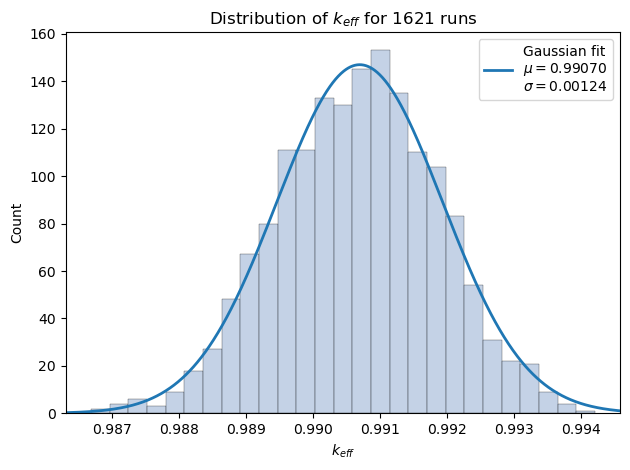

In [16]:
fig = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

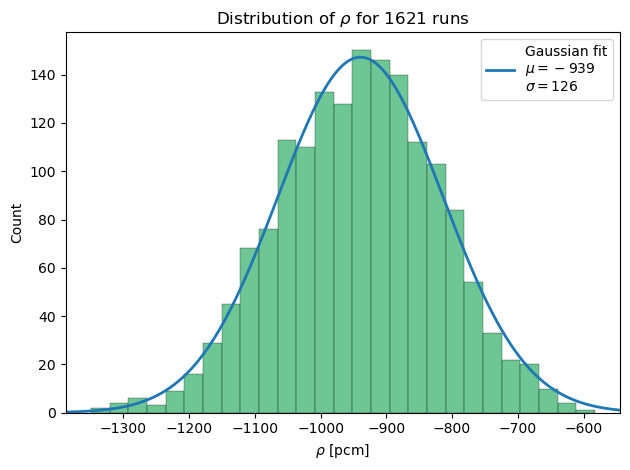

In [7]:
fig = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
                                        fit_gaussian=True, decimals=0,
                                        title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-rho"))